   # Final Project


In [137]:
import mdptoolbox
import mdptoolbox.example
import numpy as np
import scipy.constants as sc
import itertools
from sklearn.preprocessing import normalize
import matplotlib.pyplot as plt
from matplotlib import animation
from radar import *
from interference import *
from target import *

   ## Radar Environment


   The radar environment is defined by a set of possible postion states
   $\mathcal{P}$ and a set of velocity states $\mathcal{V}$.

   $\mathcal{P} = \{\mathbf{r_1}, \mathbf{r_2}, \dots, \mathbf{r_\rho}\}$

   $\mathcal{V} = \{\mathbf{v_1}, \mathbf{v_2}, \dots, \mathbf{v_\nu}\}$

   where $\rho$ is the number of possible position states and $\nu$ is the number
   of possible velocities.

   Each $\mathbf{r_i}, \mathbf{v_i}$ are 3-dimensional row vectors

   $\mathbf{r_i} = \left[r_x, r_y, r_z \right]$

   $\mathbf{v_i} = \left[v_x, v_y, v_z \right]$


   ### Interference Environment


In [138]:
N = 5
channel_bw = 200e6
subband_bw = channel_bw / N
channel = np.zeros((N,))
# Matrix of all unique interference states, where each row is a unique state and
# each column is a frequency bin
Theta = np.array(list(itertools.product([0, 1], repeat=N)))
# Interfering system
interference_state = 1
# comms = HoppingInterference(pattern=np.array(
#     [1, 2]), tx_power=4.6e-13, states=Theta)
# comms = IntermittentInterference(
# tx_power=4.6e-13, states=Theta, state_ind=interference_state,
# transition_prob=0)
comms = ConstantInterference(tx_power=4.6e-13, states=Theta,state_ind=interference_state)

   ## Simulation Environment

   ### Radar and Target Parameters

In [139]:
# Radar system
radar = Radar(position=np.zeros((3,)), prf=2000,
              center_freq=10e9, tx_gain=100, tx_power=1e3, num_pulse_cpi=20)
# Transmitted waveform (linear FM)
wave = Waveform(bandwidth=20e6, pulsewidth=10e-6)
# Possible actions (assume transmission over contiguous sub-bands)
actions = np.zeros((0, N))
for i in range(N):
    state = np.zeros((N,))
    state[:i+1] = 1
    actions = np.append(actions, np.array([np.roll(state, j) for j in
                                           range(N-i)]), axis=0)
# Number of position states in each dimension
rho_x = 5
rho_y = 5
rho_z = 1
rho = rho_x*rho_y*rho_z
rx = np.linspace(-5e3, 5e3, rho_x)
ry = np.linspace(1e3, 5e3, rho_y)
rz = np.linspace(0, 0, rho_z)
# TODO: Rename to P
r = np.vstack(np.meshgrid(rx,ry,rz)).reshape(3, -1).T
# Number of velocity states
nu = 10
# TODO: Rename to V
v = np.linspace(-1/2, 1/2, nu) * (radar.prf*radar.lambda0/2)
target = Target(position=[], velocity=[], rcs=0.1)


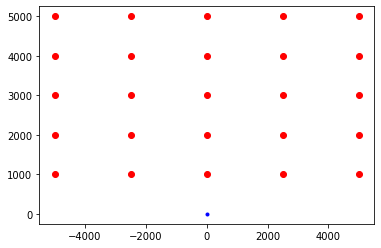

In [140]:
plt.plot(r[:,0],r[:,1],'ro',label='Position States')
plt.plot(radar.position[0],radar.position[1],'b.', label='Radar Position')

   ### Reward structure


In [141]:

def reward(radar_state, interference_state):
    r = 0
    # Number of collisions with the interference
    num_collision = np.sum(radar_state == interference_state)
    # Number of sub-bands utilized by the radar
    num_subband = np.sum(radar_state)
    # Number of missed opportunities for radar transmission, where no
    # interference exists but the radar did not transmit there
    num_missed_opportunity = np.sum(
        (radar_state == 0) & (interference_state == 0))

    if (num_collision > 0):
        r += -45*num_collision
    else:
        r += 10*(num_subband-1)
    return r

    # TODO: Penalize rapid waveform changes


In [142]:


def animate_spectrum(tx_history, interference_history):
    # tx: array of radar transmission actions, where each row is the spectrum
    # state for a test run
    # int: Array of interference states with the same shape as for the transmission

    def animate(i):
        radar_action = tx_history[i, :]
        interference_state = interference_history[i, :]
        for ibin in range(len(radar_spectrum.patches)):
            # Get the histogram bin object
            bin = radar_spectrum.patches[ibin]
            int_bin = interference.patches[ibin]
            # Set the height of each bin
            bin.set_height(radar_action[ibin])
            int_bin.set_height(interference_state[ibin])
            # Set the color of each bin based on whether or not a collision exists
            if radar_action[ibin] == interference_state[ibin]:
                bin.set_color('r')
                int_bin.set_color('r')
            else:
                bin.set_color('b')
                int_bin.set_color('g')

        return radar_spectrum.patches

    fig, ax = plt.subplots()
    plt.xlabel('Frequency (MHz)')
    plt.ylabel('State')
    subband_bw_mhz = subband_bw / 1e6
    interference = plt.bar(np.arange(N)*subband_bw_mhz, np.ones(
        (N,)), width=subband_bw_mhz, edgecolor='k', color='g', align='edge')
    radar_spectrum = plt.bar(
        np.arange(N)*subband_bw_mhz, np.ones((N,)), width=subband_bw_mhz,
        edgecolor='k', color='b', align='edge')
    anim = animation.FuncAnimation(
        fig, animate, tx_history.shape[0], repeat=False, blit=True)
    anim.save('test.gif')



   ## Train the MDP

In [143]:
# Number of possible states
# For this simulation, the set of possible states denotes all possible
# combinations of target position states, target velocity states, and
# interference states.
S = rho*nu*2**N
# Number of possible actions
A = actions.shape[0]
# Initialize the transition and reward matrices
# The first index is the action, the second is the initial state, and the third
# is the final state. The indexing for the states is position -> velocity ->
# interference-major. That is, for a given position, all velocities are
# enumerated before incrementing the position, and for a given velocity all
# interference states are enumerated. You can think of the position as the "most
# significant bit" and interference as the "least significant bit".
T = np.zeros((A, S, S))
R = np.zeros((A, S, S))

num_train = int(1e3)
num_test = int(1e0)
time = np.linspace(0, 1500, 25)
# Time step for the simulation
dt = time[1] - time[0]
for itrain in range(num_train):
    # Randomly select a starting position and target velocity
    target.position = r[np.random.choice(r.shape[0]), :]
    target.velocity = np.random.choice(v)
    # Add a gaussian perturbance to the position and velocity
    # target.position += np.random.randn()
    target.position[-1] = max(target.position[-1], 0)
    target.velocity += np.random.randn()

    # TODO: For the 3D case, the position state corresponds to the closest point
    # in 3D space
    np.linalg.norm(target.position - r, keepdims=True, axis=1)

    

    for t in time:
        # Calculate the initial state
        old_pos_state = np.linalg.norm(target.position - r,keepdims=True,axis=1).argmin()
        old_vel_state = np.digitize(target.velocity, v)-1
        old_interference_state = comms.state_ind
        old_state = old_pos_state*nu * \
            (2**N) + old_vel_state*(2**N) + old_interference_state
        # Randomly select a valid action
        action_index = np.random.randint(0, A)
        radar.action = actions[action_index, :]
        # Determine the bandwidth used, then update the interference, position, range, and SINR
        wave.bandwidth = subband_bw*np.sum(radar.action)
        comms.step()
        target.step(dt)
        sinr = radar.SINR(target, comms, wave)
        # Determine the new state
        new_pos_state = np.linalg.norm(target.position - r,keepdims=True,axis=1).argmin()
        new_vel_state = np.digitize(target.velocity, v)-1
        new_interference_state = comms.state_ind
        new_state = new_pos_state*nu * \
            (2**N) + new_vel_state*(2**N) + new_interference_state
        # Update the transition and reward matrices
        T[action_index, old_state, new_state] += 1
        R[action_index, old_state,
            new_state] += reward(radar.action, comms.current_state)
# Normalize the transition probability matrix to make it stochastic
T = np.array([normalize(T[a], axis=1, norm='l1') for a in range(A)])
# Also need to add a 1 to the diagonals of the matrices where the probability is zero
for a in range(A):
    ind = np.where(T[a].sum(axis=1) == 0)[0]
    for i in ind:
        T[a, i, i] = 1
        R[a, i, i] = 0

# Use policy iteration to determine the optimal policy
pi = mdptoolbox.mdp.PolicyIteration(T, R, 0.9)
pi.run()


 ## Test the MDP

In [144]:
current_reward = np.zeros((time.shape[0], num_test))
current_sinr = np.zeros((time.shape[0], num_test))
for itest in range(num_test):
    # Select a NEW trajectory that was not used for training
    # Randomly select a starting position and target velocity
    target.position = np.random.rand(3)*(np.max(r)-np.min(r)) + np.min(r)
    target.velocity = np.random.rand()*(np.max(v)-np.min(v)) + np.min(v)

    tx_history = np.empty((0, N))
    interference_history = np.empty((0, N))
    for itime in range(time.shape[0]):
        # Calculate the initial state
        old_pos_state = np.linalg.norm(target.position - r,keepdims=True,axis=1).argmin()
        old_vel_state = np.digitize(target.velocity, v)-1
        old_interference_state = comms.state_ind
        interference_history = np.append(interference_history, np.reshape(
            comms.current_state, (1, N)), axis=0)
        old_state = old_pos_state*nu * \
            (2**N) + old_vel_state*(2**N) + old_interference_state
        # Select an action from the policy
        radar.action = actions[pi.policy[old_state], :]
        tx_history = np.append(tx_history, np.reshape(
            radar.action, (1, N)), axis=0)

        # Determine the bandwidth used, then update the interference, position, range, and SINR
        wave.bandwidth = subband_bw*np.sum(radar.action)
        comms.step()
        target.step(dt)
        sinr = radar.SINR(target, comms, wave)
        current_sinr[itime, itest] = sinr
        if itime > 0:
            current_reward[itime, itest] = current_reward[itime -
                                                          1, itest] + reward(radar.action, comms.current_state)
        # Determine the new state
        new_pos_state = np.linalg.norm(target.position - r,keepdims=True,axis=1).argmin()
        new_vel_state = np.digitize(target.velocity, v)-1
        new_interference_state = comms.state_ind
        new_state = new_pos_state*nu * \
            (2**N) + new_vel_state*(2**N) + new_interference_state

current_reward = np.mean(current_reward, axis=1)
current_sinr = np.mean(current_sinr, axis=1)



 ## Visualizations

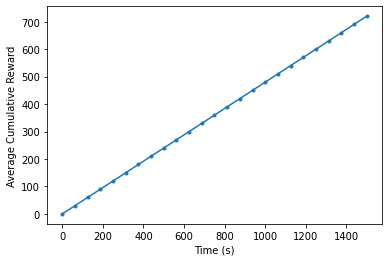

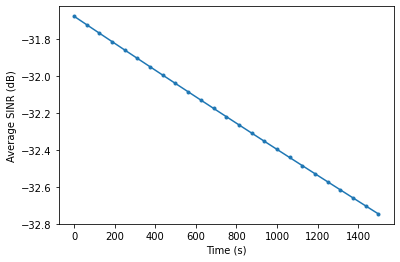

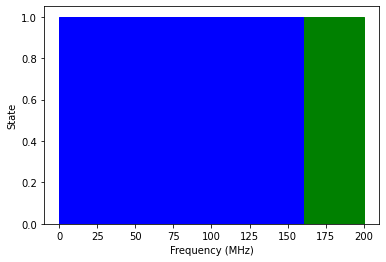

In [145]:
plt.figure()
plt.plot(time, current_reward, '.-')
plt.xlabel('Time (s)')
plt.ylabel('Average Cumulative Reward')
plt.savefig('reward')

plt.figure()
plt.plot(time, current_sinr, '.-')
plt.xlabel('Time (s)')
plt.ylabel('Average SINR (dB)')
plt.savefig('SINR')
animate_spectrum(tx_history, interference_history)